In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.spaces import Box, Discrete
from gymnasium import spaces
## import trajectory data
df = pd.read_csv('trajectory.csv')
df.head()
# df to numpy array
data = df.to_numpy()
data.shape
trajectory = np.delete(data, 2, 1)
trajectory = np.delete(trajectory, -1, 1)
trajectory.shape

(9999, 4)

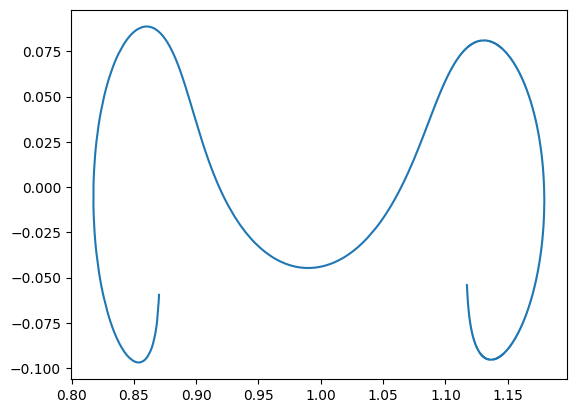

In [2]:
plt.plot(trajectory[:,0], trajectory[:,1])

In [19]:
color2num = dict(
    gray=30,
    red=31,
    green=32,
    yellow=33,
    blue=34,
    magenta=35,
    cyan=36,
    white=37,
    crimson=38
)

def colorize(string, color, bold=False, highlight=False):
    """
    Colorize a string.

    This function was originally written by John Schulman.
    """
    attr = []
    num = color2num[color]
    if highlight: num += 10
    attr.append(str(num))
    if bold: attr.append('1')
    return '\x1b[%sm%s\x1b[0m' % (';'.join(attr), string)

In [36]:
# three body problem env
class ThreeBodyEnv(gym.Env):
    def __init__(self, trajectory, error_range=0.01, final_range=0.01):
        self.trajectory = trajectory
        self.state = np.zeros(4)
        self.dt = 0.01
        self.mu = 0.012277471
        self.action_space = spaces.Box(low=-0.04, high=0.04, shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(4,), dtype=np.float32)
        self.position = trajectory[0]
        self.steps = 0
        self.max_steps = 1000
        self.final_range = final_range
        self.error_range = error_range
        self.reward_range = (-float('inf'), float('inf'))
        self.render_logic = False
        self.reset()
    
    def derivatives(self, x, y, xdot, ydot, a_x, a_y):
        r1 = np.sqrt((x + self.mu) ** 2 + y ** 2)
        r2 = np.sqrt((x - 1 + self.mu) ** 2 + y ** 2)

        xddot = 2 * ydot + x - (1 - self.mu) * ((x + self.mu) / r1**3) - self.mu * ((x - 1 + self.mu) / r2**3) + a_x
        yddot = -2 * xdot + y - (1 - self.mu) * (y / r1**3) - self.mu * (y / r2**3) + a_y

        return xddot, yddot

    def runge_kutta_step(self, x, y, xdot, ydot, a_x, a_y):
        # Calculate derivatives at the initial point
        k1_xdot, k1_ydot = self.derivatives(x, y, xdot, ydot, a_x, a_y)

        k1_x = xdot
        k1_y = ydot

        # Calculate derivatives at the midpoint
        k2_xdot, k2_ydot = self.derivatives(x + 0.5 * self.dt * k1_x, y + 0.5 * self.dt * k1_y,
                                             xdot + 0.5 * self.dt * k1_xdot, ydot + 0.5 * self.dt * k1_ydot, a_x, a_y)

        k2_x = xdot + 0.5 * self.dt * k1_xdot
        k2_y = ydot + 0.5 * self.dt * k1_ydot

        # Calculate derivatives at the next midpoint
        k3_xdot, k3_ydot = self.derivatives(x + 0.5 * self.dt * k2_x, y + 0.5 * self.dt * k2_y,
                                             xdot + 0.5 * self.dt * k2_xdot, ydot + 0.5 * self.dt * k2_ydot, a_x, a_y)

        k3_x = xdot + 0.5 * self.dt * k2_xdot
        k3_y = ydot + 0.5 * self.dt * k2_ydot

        # Calculate derivatives at the next step
        k4_xdot, k4_ydot = self.derivatives(x + self.dt * k3_x, y + self.dt * k3_y,
                                             xdot + self.dt * k3_xdot, ydot + self.dt * k3_ydot, a_x, a_y)

        k4_x = xdot + self.dt * k3_xdot
        k4_y = ydot + self.dt * k3_ydot

        # Update positions and velocities
        x += (self.dt / 6) * (k1_x + 2 * k2_x + 2 * k3_x + k4_x)
        y += (self.dt / 6) * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)

        xdot += (self.dt / 6) * (k1_xdot + 2 * k2_xdot + 2 * k3_xdot + k4_xdot)
        ydot += (self.dt / 6) * (k1_ydot + 2 * k2_ydot + 2 * k3_ydot + k4_ydot)

        return x, y, xdot, ydot

    def step(self, action):
        x = self.position[0]
        y = self.position[1]
        xdot = self.position[2]
        ydot = self.position[3]
        
        # add limit for the actions
        action = np.clip(action, self.action_space.low, self.action_space.high)

        # force = action[0] * env.state[2:] + action[1] * env.state[:2]
        a_x = action[0]/1
        a_y = action[1]/1
        

        x, y, xdot, ydot = self.runge_kutta_step(x, y, xdot, ydot, a_x, a_y)

        self.position = np.array([x, y, xdot, ydot])

        self.steps += 1

        self.position2state()

        # plot position
        if self.render_logic:
            plt.plot(x, y, 'ro')
            plt.plot(self.trajectory[:,0], self.trajectory[:,1])
            plt.show()

        reward = 1 - np.linalg.norm(self.state, axis=0) + self.steps /1000
        done = self.steps >= self.max_steps
        if np.linalg.norm(self.position[0:2] - self.trajectory[-1, 0:2]) < self.final_range:
            done = True
            reward = 10
            print(colorize("done 🥺", 'green', bold=True))
        if self.steps > 1000:
            done = True
            reward = -10
            print("end time")
        if np.linalg.norm(self.state[0:2]) > self.error_range:
            done = True
            reward = -10
            print(colorize("too much error 🥲😱", 'red', bold=True))

        # print(self.state, reward, done, self.position)
        return 1000*self.state, reward, done, False, self.position

    def position2state(self):
        # find the nearest point from position to trajectory
        distance = np.linalg.norm(self.trajectory - self.position, axis=1)
        nearest_idx = np.argmin(distance)
        # estate = position - nearest(index)
        self.state = self.position - self.trajectory[nearest_idx]

    def reset(self,
              *,
              seed: 5 = None,
              return_info: bool = False,
              options: 6 = None):
        self.position = self.trajectory[0]
        self.steps = 0
        self.position2state()
        return 10000*self.state, {}

too much error 🥲😱


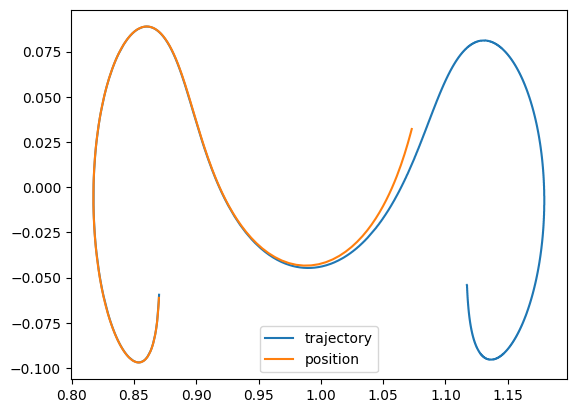

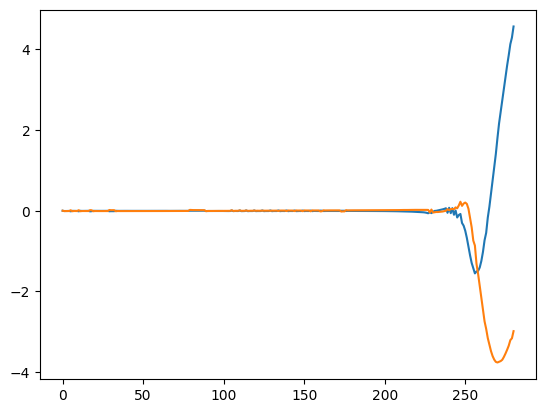

In [37]:
env = ThreeBodyEnv(trajectory)
env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(60000):
    action = -120 * env.state[2:] - 70 * env.state[:2]
    # print(action)
    action_array.append(action)
    state, reward, done, _, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legned
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)


In [5]:
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras import layers

def get_actor(num_states, upper_bound):

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh")(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

# train model
x = state_array
y = action_array

# to tensor
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)
model = get_actor(4, 1)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, verbose=1)

# Save the model
model.save('model.h5')

# load model
model = tf.keras.models.load_model('model.h5')

2024-11-01 16:42:50.667884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'tensorlayer'

In [ ]:
env = three_body_env(trajectory)
state = env.reset()
# save position
position_array = []
action_array = []
state_array = []
# using PD Guidance
for i in range(600):
    action = tf.squeeze(model(state.reshape(1,4)))
    # print(action)
    action_array.append(action)
    state, reward, done, position = env.step(action)
    state_array.append(state)
    position_array.append(position)
    if done:
        break
plt.plot(trajectory[:,0], trajectory[:,1])
plt.plot(np.array(position_array)[:,0], np.array(position_array)[:,1])
# legend
plt.legend(['trajectory', 'position'])
plt.show()
plt.plot(action_array)